<a href="https://colab.research.google.com/github/avnish-shivpure/Sentiment-Prediction-project/blob/main/Sentiment-Prediction-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sentiment-prediction-on-movie-reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F53569%2F5834979%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240418%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240418T125628Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4ef2d82f1e156e8fe8e1ea26b30c5a3d355229734f9ccc5c7e823c25fbd88de1839f31ec25f911ef75db1bef51f50ce7e8bc1f1d61771dce23cb6c0128745cab56a41b2285de2da3a33c5b822123428e23a2e148537251ef3b3bc36f64bfa0bc6af7bcf297acefb2e57d2e85dd2a26803dfaa1e5c6c239a958b2bc6df229588aa91a99233e8d2c9f62b5fbac5a9082f6e0f8e179d0017a60bb89abc16bde7ec5e600591766d39e90c12f5b3d25477b18d3b7399c10b15de9ffafa806ea7cdd198ac9e6b80049e00d9c44a710f21665cd3ec971f11924f4265e75eacb2d4900d185f5bb61b228ba03e9d9d75e3abd678db1fddcbb83d74c98a765092f7a39f959'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 21802216 bytes downloaded
Downloaded and uncompressed: sentiment-prediction-on-movie-reviews
Data source import complete.


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv


# 1. Data Preprocessing:

 The process will start by cleaning and preprocessing the reviewText column in both the training and testing datasets.
# First loading the data set

In [6]:
import regex as re #For removing the spaces and extra symbols
#importing Data
train_data= pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
test_data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
movie= pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')


# Data Metadata

In [7]:
#The shape of Train and Test is as follows:
test_data.shape, train_data.shape

((55315, 4), (162758, 5))

The Test Data has following columns

In [8]:
test_data.columns

Index(['movieid', 'reviewerName', 'isTopCritic', 'reviewText'], dtype='object')

The Train Data has following columns

In [9]:
 train_data.columns

Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'sentiment'],
      dtype='object')

In [10]:
#Descriptive statistics
train_descriptive_stats = train_data[['movieid', 'isFrequentReviewer']].describe()
test_descriptive_stats = test_data[['movieid']].describe()

print("Training Data Descriptive Statistics:")
print(train_descriptive_stats)

print("\nTest Data Descriptive Statistics:")
print(test_descriptive_stats)


Training Data Descriptive Statistics:
                                            movieid isFrequentReviewer
count                                        162758             162758
unique                                        16812                  2
top     escape_the_terminator_tyler_durden_astonish              False
freq                                            708             113189

Test Data Descriptive Statistics:
                                            movieid
count                                         55315
unique                                        16786
top     escape_the_terminator_tyler_durden_astonish
freq                                            230


# Data Visualisation

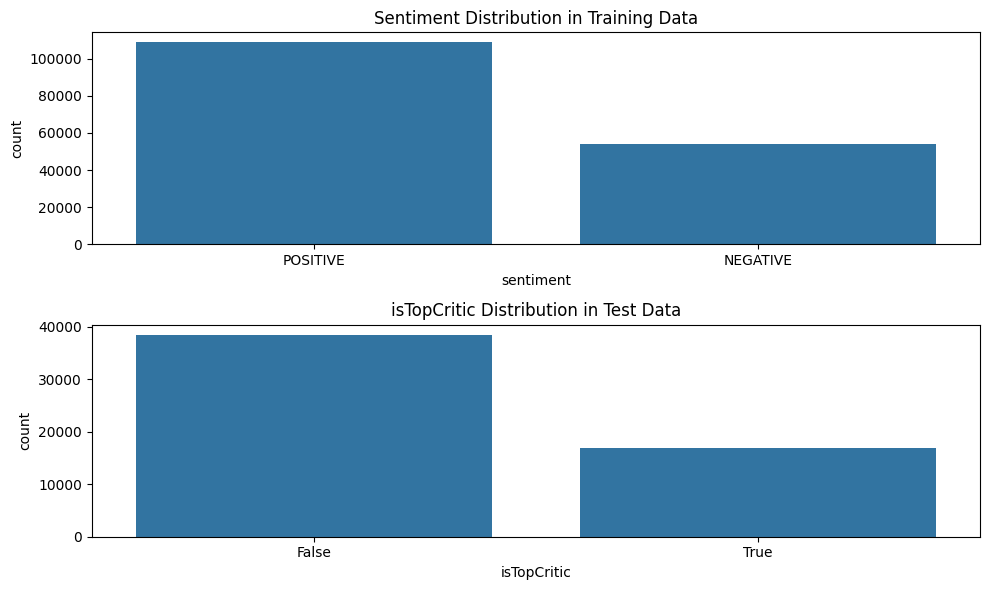

In [11]:
#Plotting graphs for visualisations
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Counting plot of sentiment in training data
plt.subplot(2, 1, 1)
sns.countplot(x='sentiment', data=train_data)
plt.title('Sentiment Distribution in Training Data')

# Count plot of isTopCritic in test data
plt.subplot(2, 1, 2)
sns.countplot(x='isTopCritic', data=test_data)
plt.title('isTopCritic Distribution in Test Data')

plt.tight_layout()
plt.show()



# Preparing the data

In [12]:
# Filling missing values in 'reviewText' column with an empty string
test_data['reviewText'] = test_data['reviewText'].fillna('')
train_data['reviewText'] = train_data['reviewText'].fillna('')

In [13]:
# Now, To Remove special characters, numbers, and convert text to lowercase
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # To Remove extra whitespace
    text = re.sub(r'[^\w\s]', '', text)  # To Remove punctuation
    return text

train_data['reviewText'] = train_data['reviewText'].apply(clean_text)
train_data['reviewerName'] = train_data['reviewerName'].apply(clean_text)
test_data['reviewText'] = test_data['reviewText'].apply(clean_text)
test_data['reviewerName'] = test_data['reviewerName'].apply(clean_text)

# Converting the text data into arrays and numbers

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
# Combine 'reviewerName' and 'reviewText' columns for vectorization
train_data['combined_text'] = train_data['reviewerName'] + ' ' + train_data['reviewText']
test_data['combined_text'] = test_data['reviewerName'] + ' ' + test_data['reviewText']

# Create a CountVectorizer instance
vectorizer = CountVectorizer()

# Fit and transform the combined training data
X_train = vectorizer.fit_transform(train_data['combined_text'])

# Transform the combined test data
X_test = vectorizer.transform(test_data['combined_text'])

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


Shape of X_train: (162758, 98968)
Shape of X_test: (55315, 98968)


In [15]:
#Converting the strings in ['sentiment'] into 1 and 0
train_data['sentiment'] = train_data['sentiment'].apply(lambda x: 1 if x == 'POSITIVE' else 0)

# Applying different model to Training data and fitting the Test data

In [16]:
#Applying Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    C = 0.3,#not less than 0.25 and higher than 1
    max_iter = 100,#not high/less than 100
    random_state = 42)
lr_model.fit(X_train, train_data['sentiment'])
#Fitting the regression model
lr_predictions = lr_model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
#Applying XGBClassifier on the data
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    max_depth=6,
    min_child_weight=1,
    gamma=0.05,
    subsample=0.8,
    colsample_bytree=1,
    learning_rate=0.3,
    n_estimators=400,
    random_state=42)
xgb_model.fit(X_train, train_data['sentiment'])
xgb_predictions = xgb_model.predict(X_test)


In [18]:
#Applying GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(
    n_estimators=100,     # Number of boosting stages to be run
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train, train_data['sentiment'])
gb_predictions = gb_model.predict(X_test)


In [19]:
#Applying Multinomial Naive bayes on the data
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, train_data['sentiment'])
nb_predictions = nb_model.predict(X_test)


# Compiling the results into a Dataframe

In [20]:
#Creating a result dataframe
results_df = pd.DataFrame({
    'id': test_data['movieid'],
    'sentiment_lr': lr_predictions,
    'sentiment_xgb': xgb_predictions,
    'sentiment_gb': gb_predictions,
    'sentiment_nb': nb_predictions
})

In [21]:
results_df.head()

,id,sentiment_lr,sentiment_xgb,sentiment_gb,sentiment_nb
0,legend_marty_mcfly_oracle,1,1,1,1
1,terminator_katniss_everdeen_glimmer,1,1,1,1
2,james_bond_labyrinth_gollum,1,1,1,1
3,v_quest_han_solo_wondrous,1,1,1,1
4,enigma_hulk_surreal_starlight,1,1,1,1


# Making the final data for submission with best possible results

In [22]:
# For each row, choose the most frequent sentiment prediction across models
results_df['sentiment_mode'] = results_df[['sentiment_lr', 'sentiment_xgb', 'sentiment_nb','sentiment_gb']].mode(axis=1)[0]

In [23]:
# Converting sentiment values to "POSITIVE" and "NEGATIVE"
results_df['sentiment'] = results_df['sentiment_mode'].apply(lambda x: 'POSITIVE' if x == 1 else 'NEGATIVE')
results_df['id'] = results_df.index
# Save the results to a CSV file
results_df[['id', 'sentiment']].to_csv('submission.csv', index=False)


# This version has submission made by mode

# For final result only Logistic Regression were taken (as even with mode same result is achieved) as it gave highest score, as it gave comparativly better score

# Insite

After converting the Text data of provided reviews into numerical array, out of all the different model applied Logistic regression gave the highest score(on sentiment prediction)